In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

# Enable memory growth to avoid using all GPU memory at once (optional)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Check if GPU is available
if len(physical_devices) > 0:
    print("GPU is available. Using GPU for computation.")
else:
    print("GPU is not available. Using CPU.")

GPU is available. Using GPU for computation.


In [4]:
data = ImageDataGenerator(rescale = 1/255.0, validation_split = 0.2)

In [5]:
train_data = data.flow_from_directory(
    directory = 'datasets/NEU-DET/train/images',
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical')

Found 1440 images belonging to 6 classes.


In [6]:
val_data = data.flow_from_directory(
    directory = 'datasets/NEU-DET/validation/images',
    target_size = (200, 200),
    batch_size = 16,
    class_mode = 'categorical')

Found 360 images belonging to 6 classes.


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
import numpy as np

In [8]:
#before dropout 

num_classes = 6

# Resnet50 base
base_model = tf.keras.applications.ResNet50V2(
    input_shape=(200, 200, 3),
    include_top=False,
    weights='imagenet',
)

# Freeze the convolutional base
base_model.trainable = False

# Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Use 'sigmoid' for multi-label classification
    
])

# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = LearningRateScheduler(lambda epoch, lr: float(lr * tf.math.exp(-0.1)), verbose=1)
opt = optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',  # 'binary_crossentropy' for multi-label classification
    metrics=['accuracy']
)

model.summary()

# Unfreeze more layers for fine-tuning
base_model.trainable = True
fine_tune_at = 50
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Adjust the learning rate for fine-tuning
opt_fine_tune = optimizers.Adam(learning_rate=0.0001)
model.compile(
    optimizer=opt_fine_tune,
    loss='categorical_crossentropy',  # 'binary_crossentropy' for multi-label classification
    metrics= ['accuracy',
              tf.keras.metrics.AUC(name='auc', multi_label=True),
              tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall')]
)

history = model.fit(train_data, steps_per_epoch= len(train_data),
                    epochs = 30, #30
                    verbose= 1,
                    validation_data = val_data, 
                    validation_steps = len(val_data), 
                    callbacks=[lr_schedule])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 24,090,886
Trainable params: 526,086
Non-trainable params: 23,564,800
______________________________________

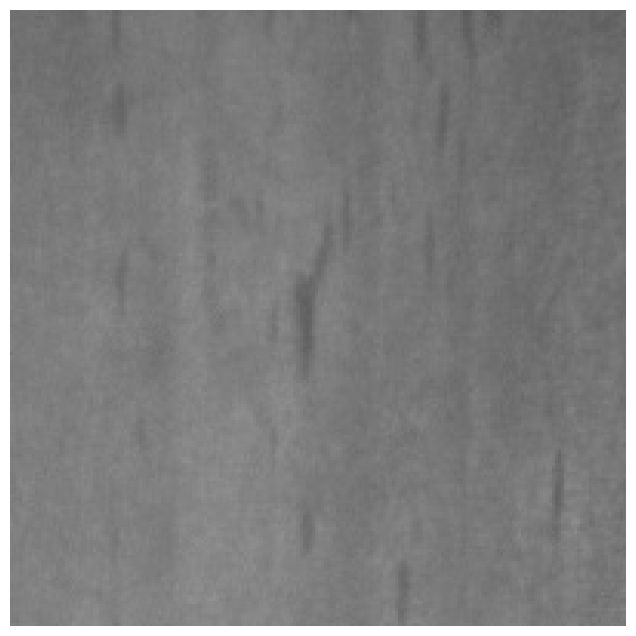

Label: [0. 0. 0. 0. 1. 0.]


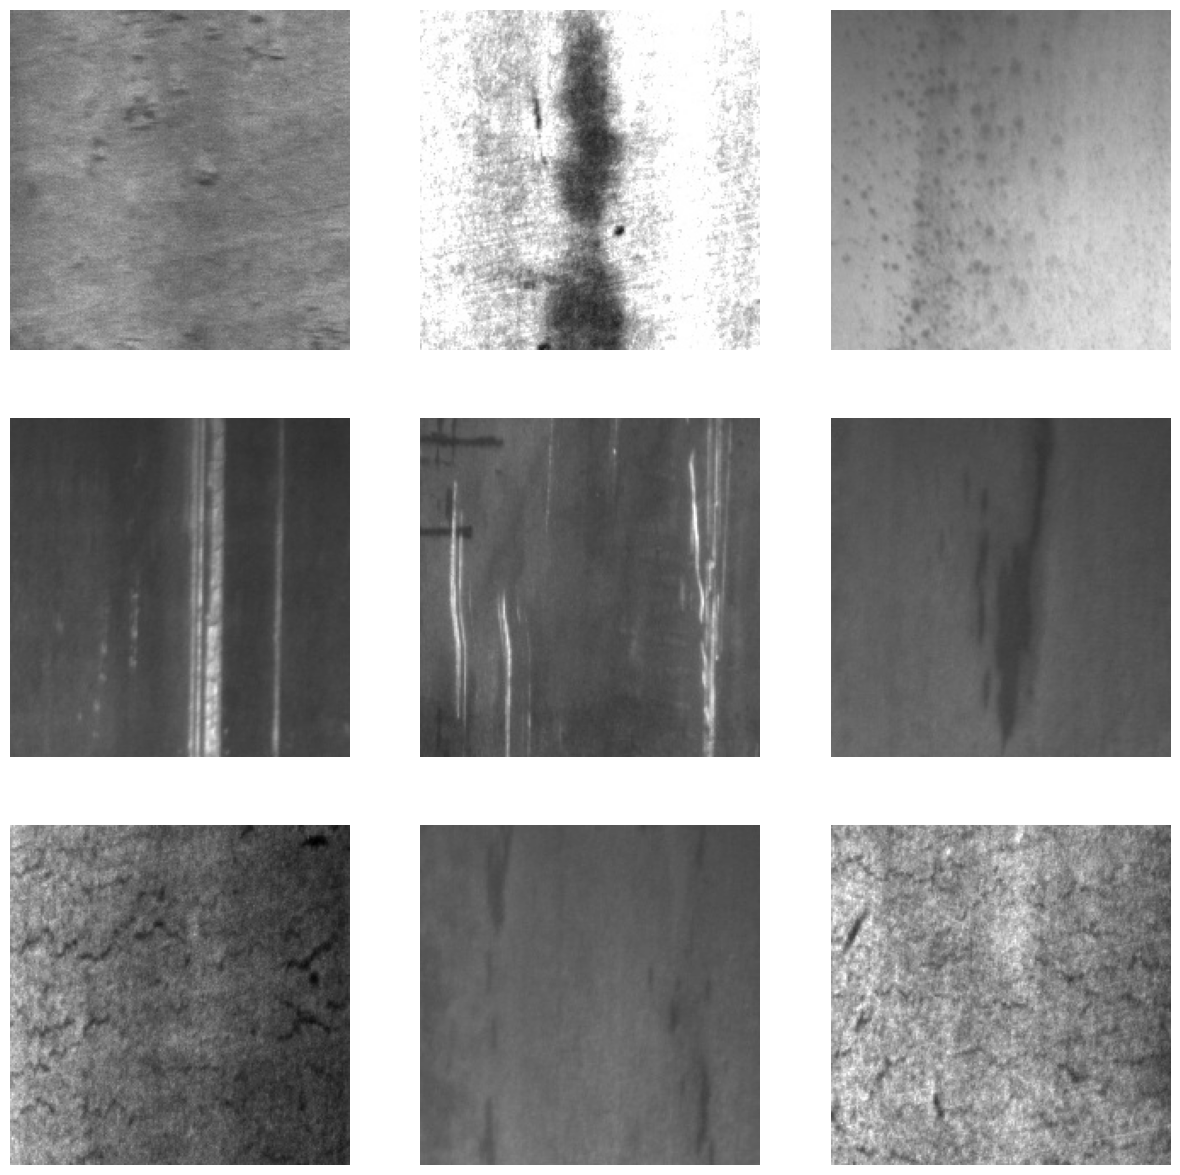

Class names: ['crazing', 'inclusion', 'patches', 'pitted_surface', 'rolled-in_scale', 'scratches']


In [9]:
# Get a single batch from the generator
images, labels = next(train_data)

# Import required libraries for visualization
import matplotlib.pyplot as plt

# Get the first image from the batch (index 0)
image = images[10]

# Display the image
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

# If you want to see the corresponding label
print("Label:", labels[0])

# To view multiple images from the batch
plt.figure(figsize=(15, 15))
for i in range(9):  # Display first 9 images
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

# You can also get class names from the generator
class_names = list(train_data.class_indices.keys())
print("Class names:", class_names)

1/1 [==============================] - 3s 3s/step
Shape of predictions: (1, 6)
Predicted class index: 5

Available class names:
{'crazing': 0, 'inclusion': 1, 'patches': 2, 'pitted_surface': 3, 'rolled-in_scale': 4, 'scratches': 5}

Number of classes: 6
Predicted class index: 5


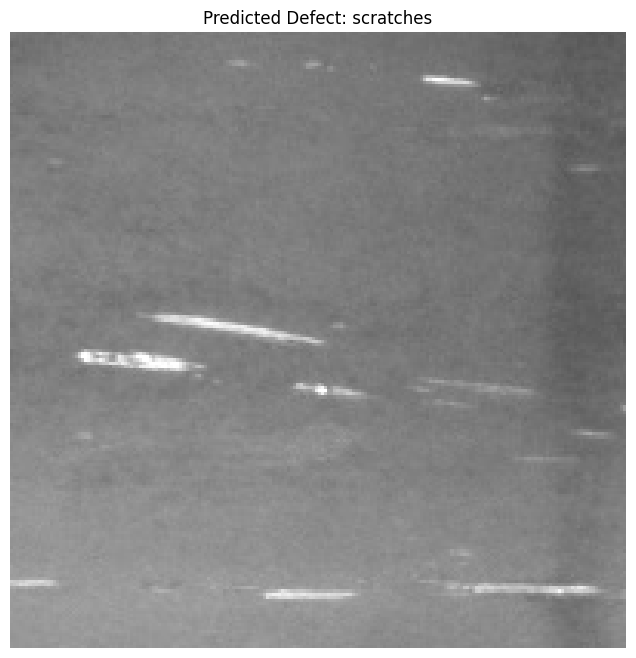

crazing: 0.00%
inclusion: 0.00%
patches: 0.00%
pitted_surface: 0.00%
rolled-in_scale: 0.00%
scratches: 100.00%


In [10]:
import numpy as np
# First, let's see what we have
images, labels = next(val_data)
single_image = images[2]
input_image = np.expand_dims(single_image, axis=0)

# Make prediction
predictions = model.predict(input_image)

# Let's print some debug information
print("Shape of predictions:", predictions.shape)
print("Predicted class index:", np.argmax(predictions[0]))

# Print the actual class_names
print("\nAvailable class names:")
print(train_data.class_indices)

# Now let's fix the visualization
predicted_class = np.argmax(predictions[0])
class_names = list(val_data.class_indices.keys())  # Get class names from data generator

# Double check if the index is valid
print("\nNumber of classes:", len(class_names))
print("Predicted class index:", predicted_class)

# Now display with verification
plt.figure(figsize=(8, 8))
plt.imshow(single_image)
if predicted_class < len(class_names):
    plt.title(f'Predicted Defect: {class_names[predicted_class]}')
else:
    plt.title(f'Predicted Class Index: {predicted_class} (Warning: Index out of range)')
plt.axis('off')
plt.show()

# Print all probabilities
for i, prob in enumerate(predictions[0]):
    if i < len(class_names):
        print(f'{class_names[i]}: {prob:.2%}')
    else:
        print(f'Class {i}: {prob:.2%}')

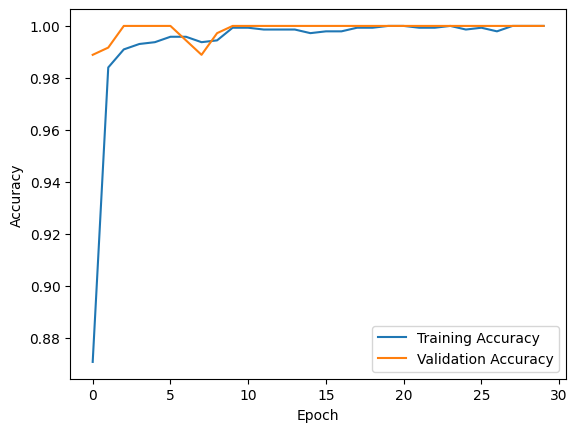

In [11]:

import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

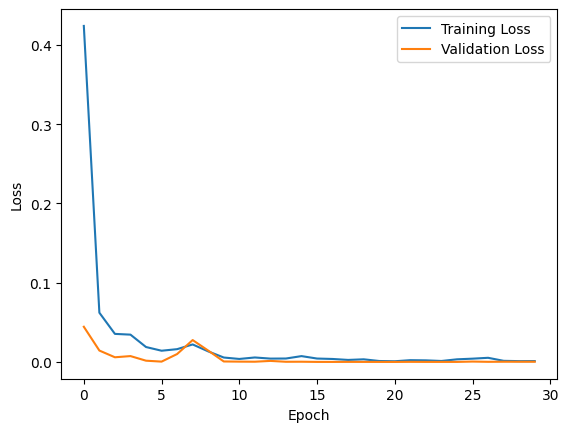

In [12]:
def plot_loss_history(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss_history(history)

In [13]:
model.save('neu_model.keras')

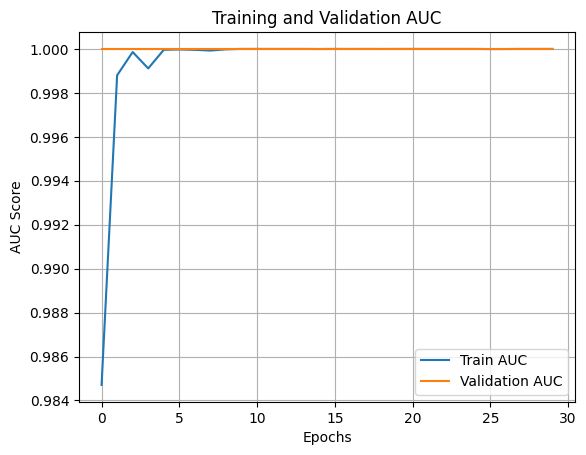

In [14]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.title('Training and Validation AUC')
plt.legend()
plt.grid(True)
plt.show()

1/1 [==============================] - 1s 677ms/step


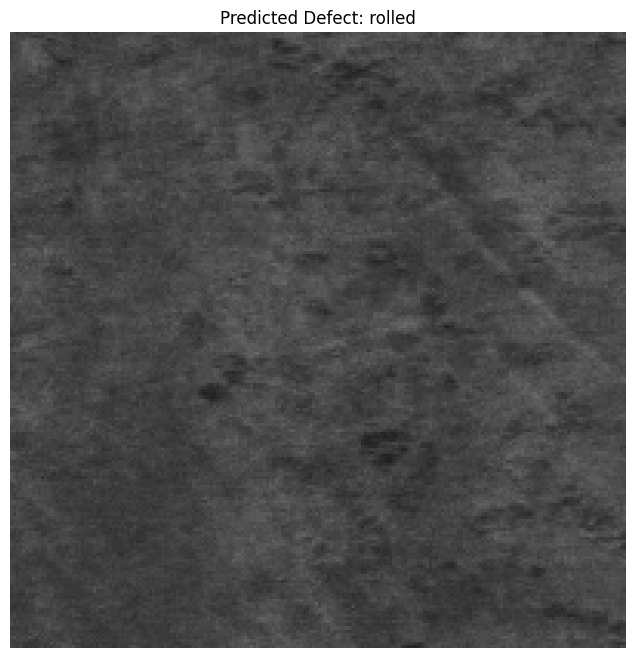


Prediction Probabilities:
crazing: 0.00%
inclusion: 0.00%
patches: 0.00%
pitted: 0.00%
rolled: 100.00%
scratches: 0.00%


In [15]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the saved model
model = load_model('neu_model.keras')

# 2. Function to predict on a single image
def predict_defect(image_path):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(200, 200))  # Use same size as training
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0  # Same normalization as training
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    
    # Define class names - replace with your actual class names
    class_names = ['crazing', 'inclusion', 'patches', 'pitted', 'rolled', 'scratches']  
    
    # Display image and prediction
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(f'Predicted Defect: {class_names[predicted_class]}')
    plt.axis('off')
    plt.show()
    
    # Print probabilities for all classes
    print("\nPrediction Probabilities:")
    for i, probability in enumerate(predictions[0]):
        print(f'{class_names[i]}: {probability:.2%}')

# 3. Use the function
predict_defect('datasets/NEU-DET/validation/images/rolled-in_scale/rolled-in_scale_252.jpg')

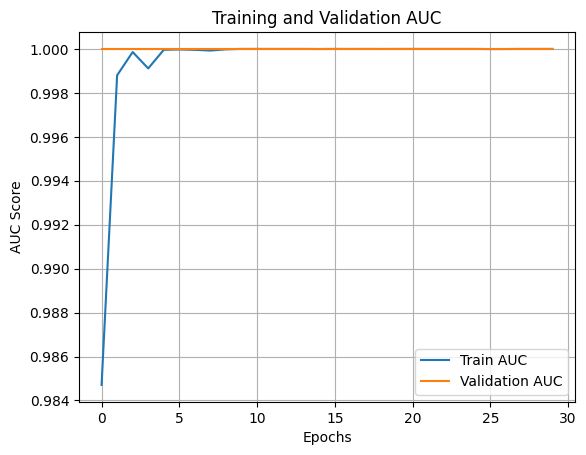

In [16]:
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.title('Training and Validation AUC')
plt.legend()
plt.grid(True)
plt.show()